# 사진 분류 인공지능 구현하기

## 모델 구조 설계

In [ ]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as utils
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn.functional as F
import time
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from torch.optim import lr_scheduler

In [ ]:
print(torch.cuda.is_available())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

True
cuda


In [ ]:
# train 데이터 전처리 : 1) 데이터 좌우반전 2) size 4만큼 패딩 후 32의 크기로 random cropping
transforms_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
transforms_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# CIFAR10 dataset 다운로드
train_val_data = dsets.CIFAR10(root='./dataset/', train=True, transform=transforms_train, download=True)
train_data, val_data = torch.utils.data.random_split(train_val_data, [40000,10000])

test_data = dsets.CIFAR10(root="./dataset/", train=False, transform=transforms_test, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

The 1st image:
tensor([[[-2.4291,  0.5756,  0.6338,  ...,  0.5368,  0.5562,  0.4787],
         [-2.4291,  0.6144,  0.6725,  ...,  0.6338,  0.5756,  0.4981],
         [-2.4291,  0.6338,  0.6919,  ...,  0.6531,  0.6144,  0.5562],
         ...,
         [-2.4291, -2.4291, -2.4291,  ..., -2.4291, -2.4291, -2.4291],
         [-2.4291, -2.4291, -2.4291,  ..., -2.4291, -2.4291, -2.4291],
         [-2.4291, -2.4291, -2.4291,  ..., -2.4291, -2.4291, -2.4291]],

        [[-2.4183,  0.6498,  0.7088,  ...,  0.6104,  0.6301,  0.5514],
         [-2.4183,  0.6891,  0.7481,  ...,  0.6891,  0.6498,  0.5711],
         [-2.4183,  0.7088,  0.7678,  ...,  0.7284,  0.6891,  0.6301],
         ...,
         [-2.4183, -2.4183, -2.4183,  ..., -2.4183, -2.4183, -2.4183],
         [-2.4183, -2.4183, -2.4183,  ..., -2.4183, -2.4183, -2.4183],
         [-2.4183, -2.4183, -2.4183,  ..., -2.4183, -2.4183, -2.4183]],

        [[-2.2214,  0.6661,  0.7247,  ...,  0.6466,  0.6466,  0.5686],
         [-2.2214,  0.7052,  0

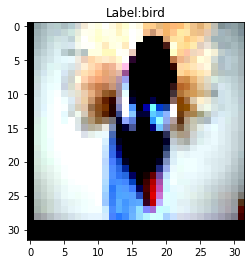

Label of this image: 2 bird


In [ ]:
image, label = train_data[0]
print("The 1st image:")
print(image)
print('Shape of this image\t:', image.shape)
plt.imshow(np.transpose(image, (1, 2, 0)))
plt.title('Label:%s' % classes[label])
plt.show()
print('Label of this image:', label, classes[label])

In [ ]:
# data 개수 확인
print('The number of training data: ', len(train_data))
print('The number of validation data: ', len(val_data))
print('The number of test data: ', len(test_data))

The number of training data:  40000
The number of validation data:  10000
The number of test data:  10000


In [ ]:
# 데이터로더, 배치사이즈, 로스함수 정의
batch_size = 128
train_batch_loader = DataLoader(train_data, batch_size, shuffle=True)
val_batch_loader = DataLoader(val_data, batch_size, shuffle=False)
criterion = nn.CrossEntropyLoss()

In [ ]:
# MLP 모델 정의
class MLP_model(nn.Module):
  def __init__(self):
    super(MLP_model, self).__init__()
    self.fc1 = nn.Linear(3*32*32, 500)
    self.fc2 = nn.Linear(500, 200)
    self.fc3 = nn.Linear(200, 100)
    self.fc4 = nn.Linear(100, 10)
  def forward(self, x):
    # img.shape: [128,3,32,32]
    # label.shape: [128]
    out = x.view(-1, 3*32*32)
    out = F.relu(self.fc1(out))
    out = F.relu(self.fc2(out))
    out = F.relu(self.fc3(out))
    out = self.fc4(out)
    return out

In [ ]:
# 모델 정의
model = MLP_model()
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# 학습 시작
start_time = time.time()
highest_val_acc = 0
loss_list = []
val_acc_list = []
global_steps = 0
epoch = 0

print('========================================')
print("Start training...")
while True:
    train_loss = 0
    train_batch_cnt = 0
    model.train()
    for img, label in train_batch_loader:
        global_steps += 1
        # img.shape: [128,3,32,32]
        # label.shape: [128]
        img = img.to(device)
        label = label.to(device)
        optimizer.zero_grad()
        outputs = model(img)
        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()
        train_loss += loss
        train_batch_cnt += 1

        loss_list.append(loss.item())        

        if global_steps >= 15000:
            print("Training finished.")
            break

    ave_loss = train_loss / train_batch_cnt
    training_time = (time.time() - start_time) / 60
    print('========================================')
    print("epoch:", epoch + 1, "/ global_steps:", global_steps)
    print("training dataset average loss: %.3f" % ave_loss)
    print("training_time: %.2f minutes" % training_time)

    # validation (for early stopping)
    correct_cnt = 0
    model.eval()
    for img, label in val_batch_loader:
        img = img.to(device)
        label = label.to(device)
        pred = model.forward(img)
        _, top_pred = torch.topk(pred, k=1, dim=-1)
        top_pred = top_pred.squeeze(dim=1)
        correct_cnt += int(torch.sum(top_pred == label))

    val_acc = correct_cnt / len(val_data) * 100
    print("validation dataset accuracy: %.2f" % val_acc)
    val_acc_list.append(val_acc)
    if val_acc > highest_val_acc:
        save_path = './' + str(epoch + 1) + '.pth'
        # 위와 같이 저장 위치를 바꾸어 가며 각 setting의 epoch마다의 state를 저장할 것.
        torch.save({'epoch': epoch + 1,
                    'model_state_dict': model.state_dict()},
                    save_path)
        highest_val_acc = val_acc
    epoch += 1
    if global_steps >= 15000:
        break

Start training...
epoch: 1 / global_steps: 313
training dataset average loss: 1.832
training_time: 0.30 minutes
validation dataset accuracy: 38.09
epoch: 2 / global_steps: 626
training dataset average loss: 1.662
training_time: 0.58 minutes
validation dataset accuracy: 41.33
epoch: 3 / global_steps: 939
training dataset average loss: 1.588
training_time: 0.86 minutes
validation dataset accuracy: 42.30
epoch: 4 / global_steps: 1252
training dataset average loss: 1.541
training_time: 1.14 minutes
validation dataset accuracy: 44.75
epoch: 5 / global_steps: 1565
training dataset average loss: 1.505
training_time: 1.43 minutes
validation dataset accuracy: 46.10
epoch: 6 / global_steps: 1878
training dataset average loss: 1.476
training_time: 1.70 minutes
validation dataset accuracy: 46.50
epoch: 7 / global_steps: 2191
training dataset average loss: 1.462
training_time: 1.98 minutes
validation dataset accuracy: 46.36
epoch: 8 / global_steps: 2504
training dataset average loss: 1.438
training

In [ ]:
test_data = dsets.CIFAR10(root="./dataset/", train=False, transform=transforms_test, download=True)
test_batch_loader = DataLoader(test_data, batch_size, shuffle=False)
model.eval()
checkpoint = torch.load(save_path)
model.load_state_dict(checkpoint['model_state_dict'])
epoch = checkpoint['epoch']
correct_cnt = 0
with torch.no_grad():
  for img, label in test_batch_loader:
    img = img.to(device)
    label = label.to(device)
    pred = model.forward(img)
    _, top_pred = torch.topk(pred, k=1, dim=-1)
    top_pred = top_pred.squeeze(dim=1)
    correct_cnt += int(torch.sum(top_pred == label))
    
test_acc = correct_cnt / len(test_data) * 100
print("test data accuracy : %.2f"%(test_acc))

Files already downloaded and verified
test data accuracy : 50.27


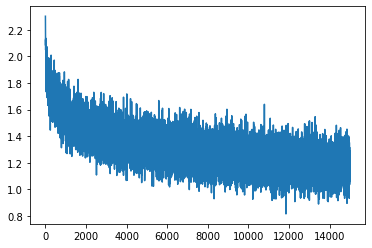

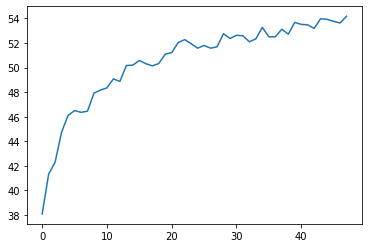

In [ ]:
plt.plot(loss_list)
plt.show()
plt.plot(val_acc_list)
plt.show()

In [ ]:
# LeNet5 model

class LeNet5_model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        # input channels, output channels, kernel size
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # kernel size, stride, padding = 0 (default)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # input features, output features
        self.fc2 = nn.Linear(120, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
model = LeNet5_model()
model = model.to(device)

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
start_time = time.time()
highest_val_acc = 0
loss_list = []
val_acc_list = []
global_steps = 0
epoch = 0

print('========================================')
print("Start training...")
while True:
    train_loss = 0
    train_batch_cnt = 0
    model.train()
    for img, label in train_batch_loader:
        global_steps += 1
        # img.shape: [128,3,32,32]
        # label.shape: [128]
        img = img.to(device)
        label = label.to(device)
        optimizer.zero_grad()
        outputs = model(img)
        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()
        train_loss += loss
        train_batch_cnt += 1

        loss_list.append(loss.item())        

        if global_steps >= 15000:
            print("Training finished.")
            break

    ave_loss = train_loss / train_batch_cnt
    training_time = (time.time() - start_time) / 60
    print('========================================')
    print("epoch:", epoch + 1, "/ global_steps:", global_steps)
    print("training dataset average loss: %.3f" % ave_loss)
    print("training_time: %.2f minutes" % training_time)

    # validation (for early stopping)
    correct_cnt = 0
    model.eval()
    for img, label in val_batch_loader:
        img = img.to(device)
        label = label.to(device)
        pred = model.forward(img)
        _, top_pred = torch.topk(pred, k=1, dim=-1)
        top_pred = top_pred.squeeze(dim=1)
        correct_cnt += int(torch.sum(top_pred == label))

    val_acc = correct_cnt / len(val_data) * 100
    print("validation dataset accuracy: %.2f" % val_acc)
    val_acc_list.append(val_acc)
    if val_acc > highest_val_acc:
        save_path = './' + str(epoch + 1) + '.pth'
        # 위와 같이 저장 위치를 바꾸어 가며 각 setting의 epoch마다의 state를 저장할 것.
        torch.save({'epoch': epoch + 1,
                    'model_state_dict': model.state_dict()},
                    save_path)
        highest_val_acc = val_acc
    epoch += 1
    if global_steps >= 15000:
        break

Start training...
epoch: 1 / global_steps: 313
training dataset average loss: 1.789
training_time: 0.31 minutes
validation dataset accuracy: 40.24
epoch: 2 / global_steps: 626
training dataset average loss: 1.553
training_time: 0.60 minutes
validation dataset accuracy: 45.29
epoch: 3 / global_steps: 939
training dataset average loss: 1.458
training_time: 0.88 minutes
validation dataset accuracy: 48.17
epoch: 4 / global_steps: 1252
training dataset average loss: 1.383
training_time: 1.17 minutes
validation dataset accuracy: 51.20
epoch: 5 / global_steps: 1565
training dataset average loss: 1.328
training_time: 1.47 minutes
validation dataset accuracy: 51.75
epoch: 6 / global_steps: 1878
training dataset average loss: 1.295
training_time: 1.76 minutes
validation dataset accuracy: 53.35
epoch: 7 / global_steps: 2191
training dataset average loss: 1.266
training_time: 2.05 minutes
validation dataset accuracy: 54.50
epoch: 8 / global_steps: 2504
training dataset average loss: 1.244
training

## Test

In [ ]:
test_data = dsets.CIFAR10(root="./dataset/", train=False, transform=transforms_test, download=True)
test_batch_loader = DataLoader(test_data, batch_size, shuffle=False)
model.eval()
checkpoint = torch.load(save_path)
model.load_state_dict(checkpoint['model_state_dict'])
epoch = checkpoint['epoch']
correct_cnt = 0
with torch.no_grad():
  for img, label in test_batch_loader:
    img = img.to(device)
    label = label.to(device)
    pred = model.forward(img)
    _, top_pred = torch.topk(pred, k=1, dim=-1)
    top_pred = top_pred.squeeze(dim=1)
    correct_cnt += int(torch.sum(top_pred == label))
    
test_acc = correct_cnt / len(test_data) * 100
print("test data accuracy : %.2f"%(test_acc))

Files already downloaded and verified
test data accuracy : 68.47


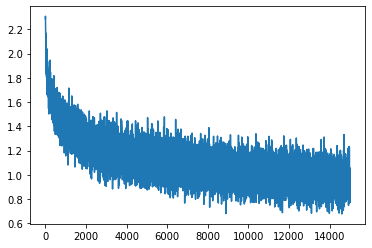

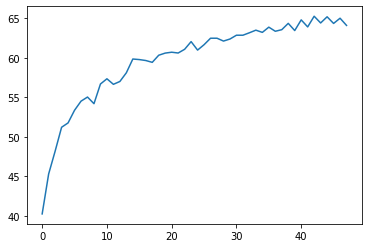

In [ ]:
plt.plot(loss_list)
plt.show()
plt.plot(val_acc_list)
plt.show()

In [ ]:
# 사전학습된 ResNet 불러오기
resnet = models.resnet50(pretrained=True).to(device)

# 모델 summary 출력
from torchsummary import summary
summary(resnet, input_size=(3, 224, 224), device=device.type)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:
# 이미지 불러오기
from google.colab import files
img = files.upload()

Saving cat.jpg to cat.jpg


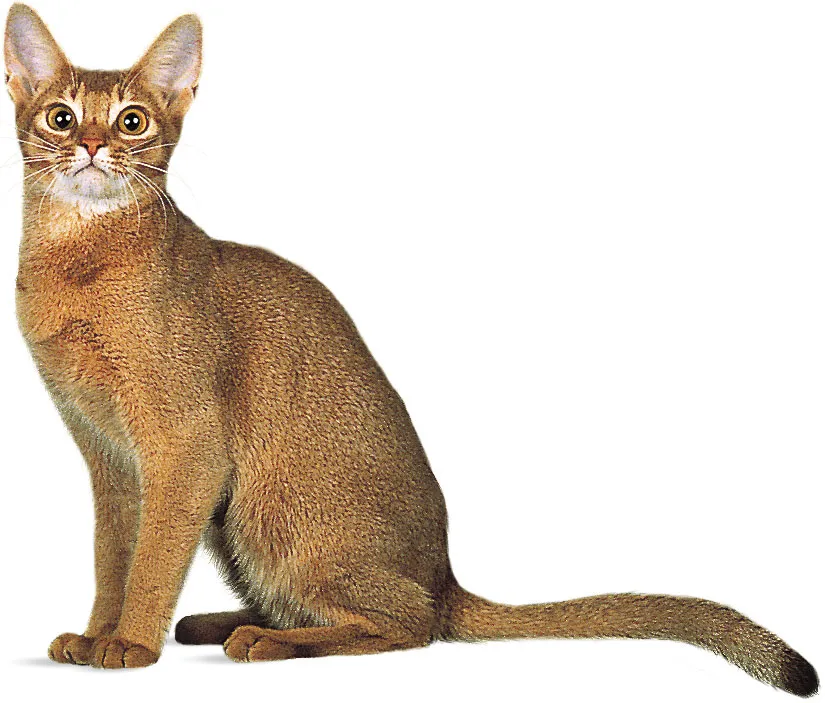

In [ ]:
from PIL import Image
img = Image.open('/content/cat.jpg').convert('RGB')
img

In [ ]:
# 데이터 전처리
from torchvision import transforms
preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

])
img_preprocessed = preprocess(img)
batch_img_tensor = torch.unsqueeze(img_preprocessed, 0)

In [ ]:
# 테스트용 이미지 결과 출력
resnet.eval()
out = resnet(batch_img_tensor.to(device))

In [ ]:
# imagenet class 불러오기 (imagenet_classes.txt)
# txt파일을 한번 열어 보세요!
from google.colab import files
classes = files.upload()

Saving imagenet_classes.txt to imagenet_classes.txt


In [ ]:
# imagenet의 클래스 분류를 통한 최종결과 확인
with open('/content/imagenet_classes.txt') as f:
    labels = [line.strip() for line in f.readlines()]
_, index = torch.max(out, 1)
percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100
print(labels[index[0]], percentage[index[0]].item())

285, Egyptian_cat 52.66728973388672


In [ ]:
# 상위 5개 클래스 보여줌
_, indices = torch.sort(out, descending=True)
[(labels[idx], percentage[idx].item()) for idx in indices[0][:5]]

[('285, Egyptian_cat', 52.66728973388672),
 ('331, hare', 19.815946578979492),
 ('104, wallaby', 5.0467987060546875),
 ('298, mongoose', 3.409334659576416),
 ('277, red_fox', 3.145502805709839)]